In [1]:
%load_ext autoreload
%autoreload 2

## Import Libraries

In [2]:
# Future print function
from __future__ import print_function

# Installing latest Albumentation library
!pip install -U git+https://github.com/albu/albumentations -q --quiet
# Install LR Finder
!pip install torch-lr-finder -q --quiet
# Install grad-cam library
!pip install grad-cam

# For inline matplotlib plotting
%matplotlib inline

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 48.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38247 sha256=f6acb873c9681bad9d71e3369e8487160854d9e2ca45200e280e3c6f8f2dc14c
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


## Loading Train & Test data and creating the train and test loaders

In [3]:
from utils import *

# Loading test and train data & dataloader
cifar10 = dataset_cifar10(batch_size=512)

# Train dataloader
trainloader = cifar10.loader(train_flag=True)

# Test dataloader
testloader = cifar10.loader(train_flag=False)

classes = cifar10.classes

CUDA availability ? True


/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


100%|██████████| 170498071/170498071 [00:13<00:00, 12719504.54it/s]


Extracting ./Data/cifar-10-python.tar.gz to ./Data
Files already downloaded and verified


## Summary Statistics

In [4]:
cifar10.data_summary_stats()

Files already downloaded and verified
Files already downloaded and verified
(60000, 32, 32, 3)
[0.49186878 0.48265391 0.44717728]
[0.24697121 0.24338894 0.26159259]


## Plotting sample training Images

Files already downloaded and verified


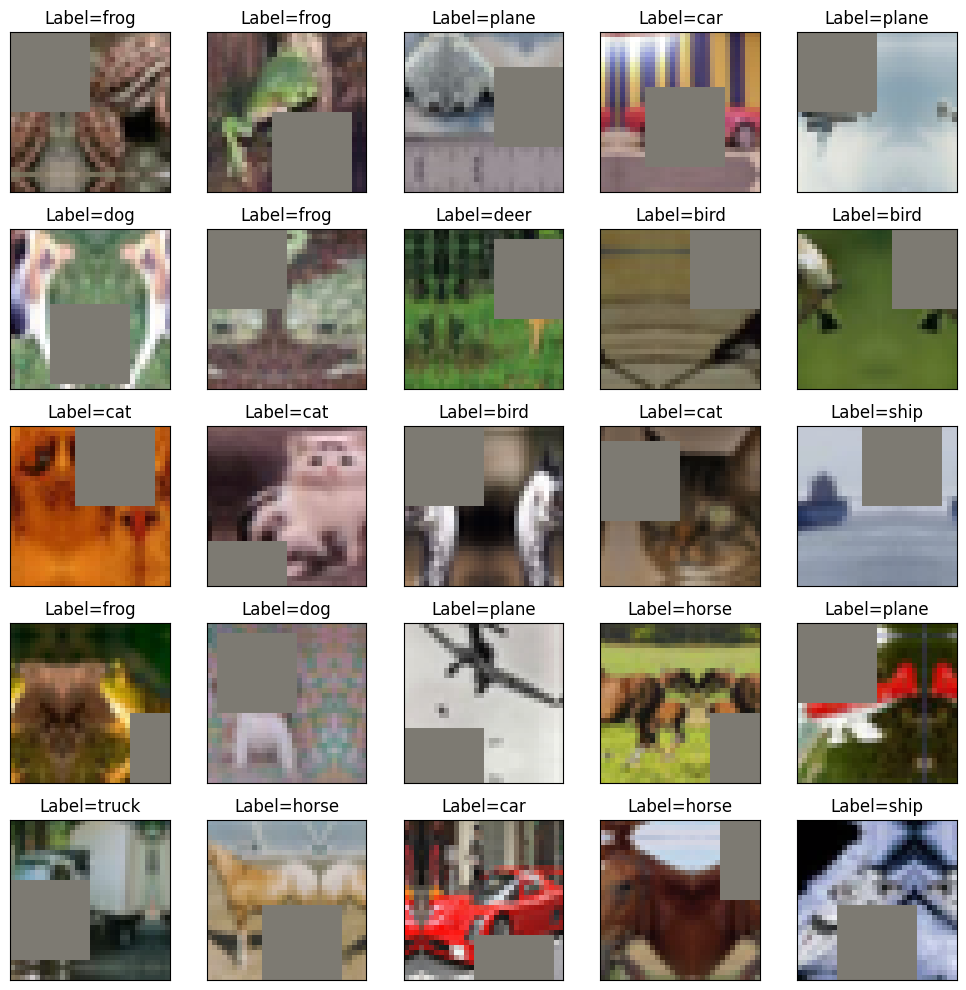

In [5]:
cifar10.sample_pictures(train_flag=True)

# Loading Model

In [51]:
from model import *

# Loading Custom Model
net_18 = ResNet18()
net_34 = ResNet34()
# Using cuda if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

# Sending network to device
net_18 = net_18.to(device)
net_34 = net_34.to(device)

cuda


## Model Summary

In [31]:
!pip install torchsummary
from torchsummary import summary

# Model Summary
summary(net_18, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [32]:
# Model Summary
# summary(net_34, input_size=(3, 32, 32))

## LR Finder - ResNet18

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.07E-03


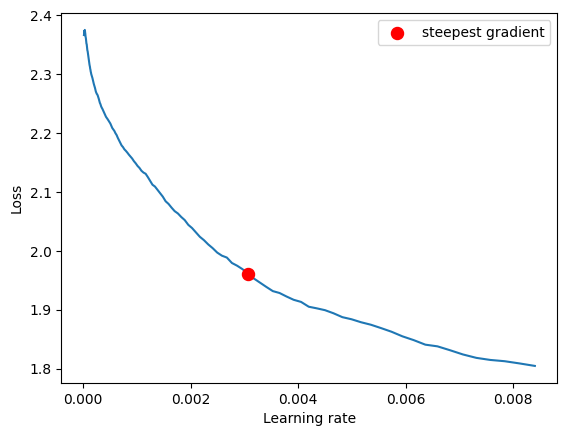

In [15]:
#https://github.com/davidtvs/pytorch-lr-finder

import copy
import torch
from torch_lr_finder import LRFinder
import torch.nn as nn
import torch.optim as optim
import numpy as np

net_exp_18 = copy.deepcopy(net_18)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_exp_18.parameters(), lr=1e-3, momentum=0.85)
lr_finder = LRFinder(net_exp_18, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, start_lr=1e-5, end_lr=0.01, num_iter=200, step_mode="exp")
lr_finder.plot(log_lr=False)
lr_finder.reset()

## Define Loss & Optimizers

In [52]:
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_18.parameters(), lr=0.01, momentum=0.85)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.2)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=2E-2, steps_per_epoch=len(trainloader),
                                                epochs=20,pct_start=0.2,
                                                anneal_strategy='linear')

# Training & Testing the Model - ResNet18

In [54]:
# Load train and test model
from main_new import *

train = train()
test = test()

EPOCHS= 20
train_loss = []
test_loss = []
for epoch in range(EPOCHS):  # loop over the dataset multiple times
  #train.execute(net, device, batch, optimizer, criterion, epoch)
  train_loss.append(train.execute(net_18, device, trainloader, optimizer, scheduler, criterion, epoch))
  test_loss.append(test.execute(net_18, device, testloader, criterion))

print('Finished Training ResNet18')

Epoch: 0,Loss=1.54 Batch_id=97 Accuracy=31.80: 100%|██████████| 98/98 [00:40<00:00,  2.44it/s]


Test set: Average loss: 0.0031, Accuracy: 4314/10000 (43.14%)



Epoch: 1,Loss=1.34 Batch_id=97 Accuracy=47.79: 100%|██████████| 98/98 [00:40<00:00,  2.42it/s]


Test set: Average loss: 0.0025, Accuracy: 5382/10000 (53.82%)



Epoch: 2,Loss=1.20 Batch_id=97 Accuracy=54.40: 100%|██████████| 98/98 [00:41<00:00,  2.38it/s]


Test set: Average loss: 0.0024, Accuracy: 5937/10000 (59.37%)



Epoch: 3,Loss=1.12 Batch_id=97 Accuracy=59.06: 100%|██████████| 98/98 [00:41<00:00,  2.39it/s]


Test set: Average loss: 0.0023, Accuracy: 6078/10000 (60.78%)



Epoch: 4,Loss=1.07 Batch_id=97 Accuracy=63.04: 100%|██████████| 98/98 [00:41<00:00,  2.38it/s]


Test set: Average loss: 0.0018, Accuracy: 6839/10000 (68.39%)



Epoch: 5,Loss=0.86 Batch_id=97 Accuracy=65.75: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


Test set: Average loss: 0.0018, Accuracy: 6985/10000 (69.85%)



Epoch: 6,Loss=0.82 Batch_id=97 Accuracy=68.47: 100%|██████████| 98/98 [00:41<00:00,  2.36it/s]


Test set: Average loss: 0.0019, Accuracy: 6871/10000 (68.71%)



Epoch: 7,Loss=0.88 Batch_id=97 Accuracy=70.10: 100%|██████████| 98/98 [00:41<00:00,  2.36it/s]


Test set: Average loss: 0.0014, Accuracy: 7577/10000 (75.77%)



Epoch: 8,Loss=0.74 Batch_id=97 Accuracy=71.78: 100%|██████████| 98/98 [00:41<00:00,  2.36it/s]


Test set: Average loss: 0.0014, Accuracy: 7546/10000 (75.46%)



Epoch: 9,Loss=0.63 Batch_id=97 Accuracy=73.60: 100%|██████████| 98/98 [00:41<00:00,  2.36it/s]


Test set: Average loss: 0.0014, Accuracy: 7618/10000 (76.18%)



Epoch: 10,Loss=0.72 Batch_id=97 Accuracy=74.64: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


Test set: Average loss: 0.0014, Accuracy: 7674/10000 (76.74%)



Epoch: 11,Loss=0.66 Batch_id=97 Accuracy=75.91: 100%|██████████| 98/98 [00:41<00:00,  2.36it/s]


Test set: Average loss: 0.0014, Accuracy: 7668/10000 (76.68%)



Epoch: 12,Loss=0.73 Batch_id=97 Accuracy=77.30: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


Test set: Average loss: 0.0011, Accuracy: 8184/10000 (81.84%)



Epoch: 13,Loss=0.60 Batch_id=97 Accuracy=78.14: 100%|██████████| 98/98 [00:41<00:00,  2.36it/s]


Test set: Average loss: 0.0010, Accuracy: 8282/10000 (82.82%)



Epoch: 14,Loss=0.63 Batch_id=97 Accuracy=78.91: 100%|██████████| 98/98 [00:41<00:00,  2.36it/s]


Test set: Average loss: 0.0010, Accuracy: 8373/10000 (83.73%)



Epoch: 15,Loss=0.53 Batch_id=97 Accuracy=79.78: 100%|██████████| 98/98 [00:41<00:00,  2.36it/s]


Test set: Average loss: 0.0011, Accuracy: 8186/10000 (81.86%)



Epoch: 16,Loss=0.51 Batch_id=97 Accuracy=80.99: 100%|██████████| 98/98 [00:41<00:00,  2.36it/s]


Test set: Average loss: 0.0008, Accuracy: 8562/10000 (85.62%)



Epoch: 17,Loss=0.43 Batch_id=97 Accuracy=81.88: 100%|██████████| 98/98 [00:42<00:00,  2.33it/s]


Test set: Average loss: 0.0008, Accuracy: 8579/10000 (85.79%)



Epoch: 18,Loss=0.53 Batch_id=97 Accuracy=82.77: 100%|██████████| 98/98 [00:41<00:00,  2.36it/s]


Test set: Average loss: 0.0007, Accuracy: 8726/10000 (87.26%)



Epoch: 19,Loss=0.45 Batch_id=91 Accuracy=83.85:  94%|█████████▍| 92/98 [00:40<00:02,  2.28it/s]


ValueError: ignored

## Loss Curves

Text(0.5, 1.0, 'Epochs Vs Train Loss')

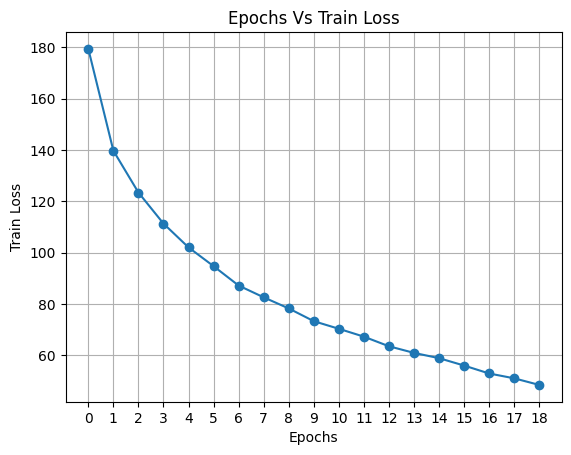

In [59]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(train_loss)),train_loss,label='train_loss',marker='o')
#plt.plot(np.arange(19),test_loss,label='test_loss',marker='o')
plt.xticks(np.arange(len(train_loss)))
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.title('Epochs Vs Train Loss')

## Display Images of testset

Files already downloaded and verified


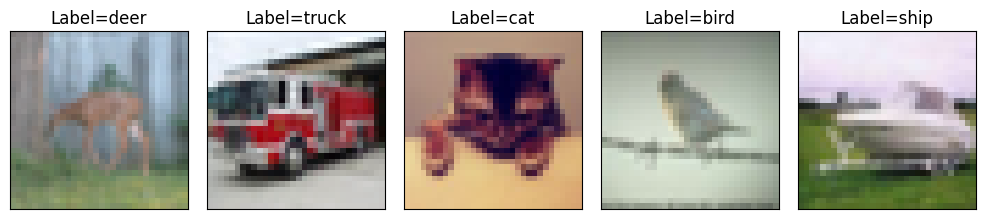

In [60]:
images, labels = cifar10.sample_pictures(train_flag=False, return_flag = True)

## Predictions on samples of Testset

In [62]:
images,labels = images.to(device),labels.to(device)
outputs = net_18(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(5)))

Predicted:   deer truck  frog  bird plane


## Grad-CAM on 10 misclassified images

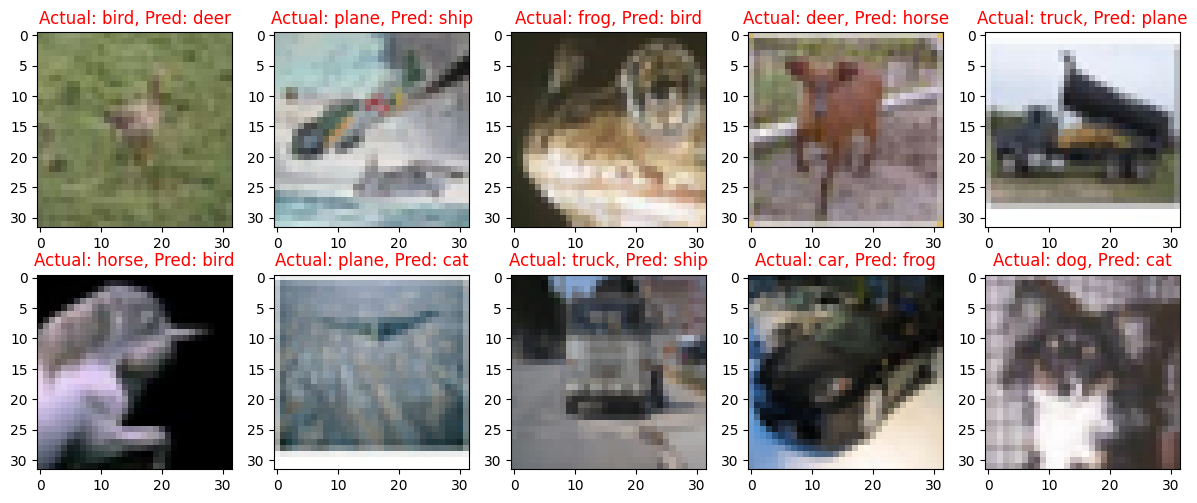

In [68]:
from utils import *
plot_misclassified_images(net_18, testloader, classes, device)

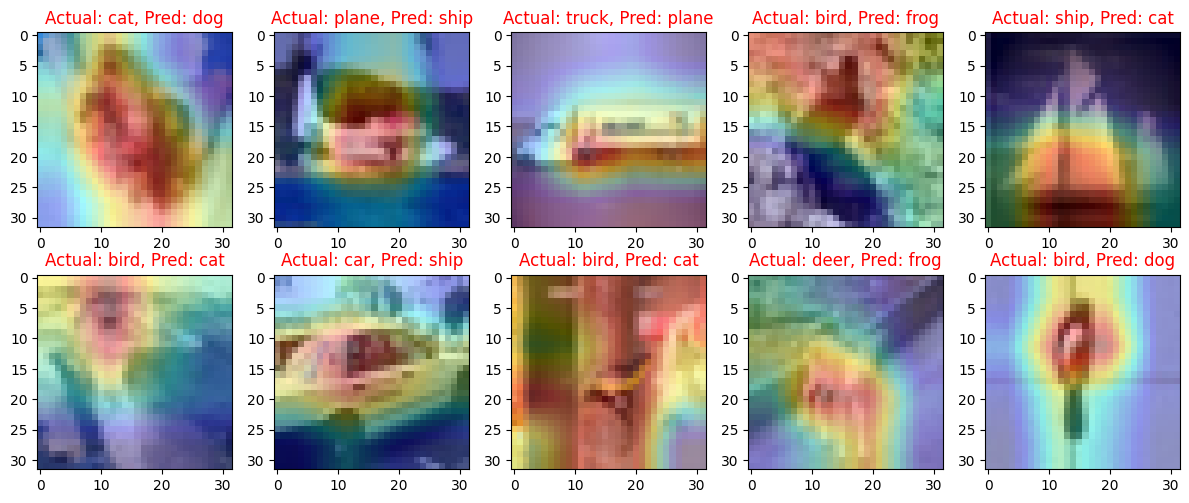

In [69]:
plot_grad_cam_images(net_18, testloader, classes, device)

## Evaluating Training Accuracy

In [70]:
from evaluate import *
calAccuracy(net_18, trainloader, device)

Accuracy of the network on the  train images: 84.046 %%


## Evaluating Test Accuracy

In [73]:
calAccuracy(net_18, testloader, device)

Accuracy of the network on the  train images: 87.81 %%


## Evaluating Test Accuracy across different classes

In [74]:
calClassAccuracy(net_18, testloader,classes, device)

Accuracy of plane : 85 %
Accuracy of   car : 100 %
Accuracy of  bird : 100 %
Accuracy of   cat : 100 %
Accuracy of  deer : 90 %
Accuracy of   dog : 70 %
Accuracy of  frog : 100 %
Accuracy of horse : 77 %
Accuracy of  ship : 100 %
Accuracy of truck : 78 %
